In [2]:
from collections import Counter
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import os
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV, LogisticRegressionCV, LassoCV, MultiTaskLassoCV, ElasticNetCV, MultiTaskElasticNetCV
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from scipy.constants import convert_temperature
import numpy as np

import warnings
warnings.filterwarnings('ignore')



def set_fig_size(width=18,height=10):
    fig,ax=plt.subplots(1,1)
    fig.set_size_inches(width,height)
    

def set_font_size(size=18):
    font = {'family' : 'verdana',
            'size'   : size}
    rc('font', **font)
    
def make_big(f=18,w=18,h=10):
    set_font_size(size=f)
    set_fig_size(width=w,height=h)
    
df = pd.read_csv('training_data.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
df.describe().T


df = df.sort_values(by='datetime')
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
7895,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
6779,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
6508,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
4087,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
4531,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...
2894,2012-12-19 18:00:00,4,0,1,1,15.58,19.695,50,23.9994,23,546,569
2079,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
217,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
4926,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


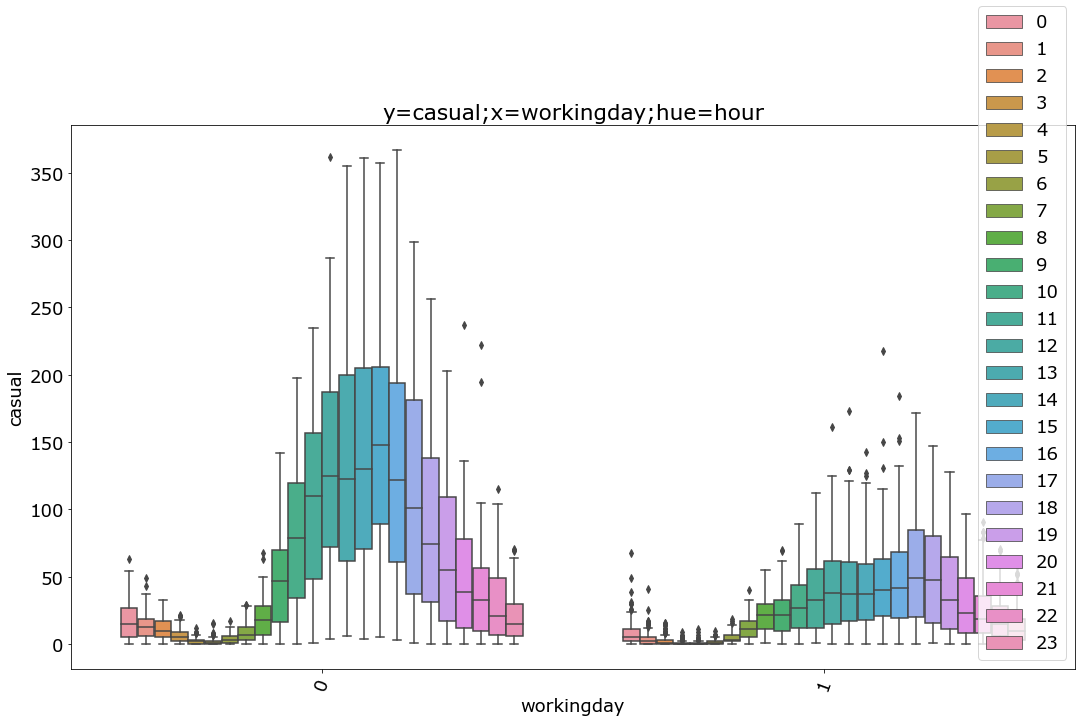

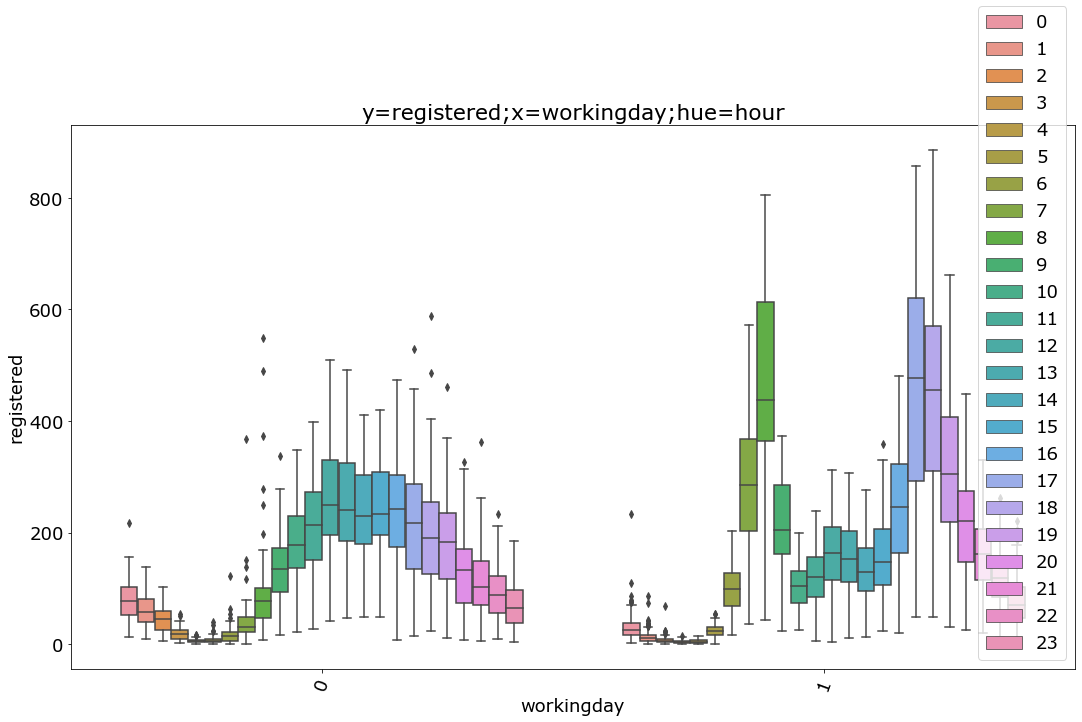

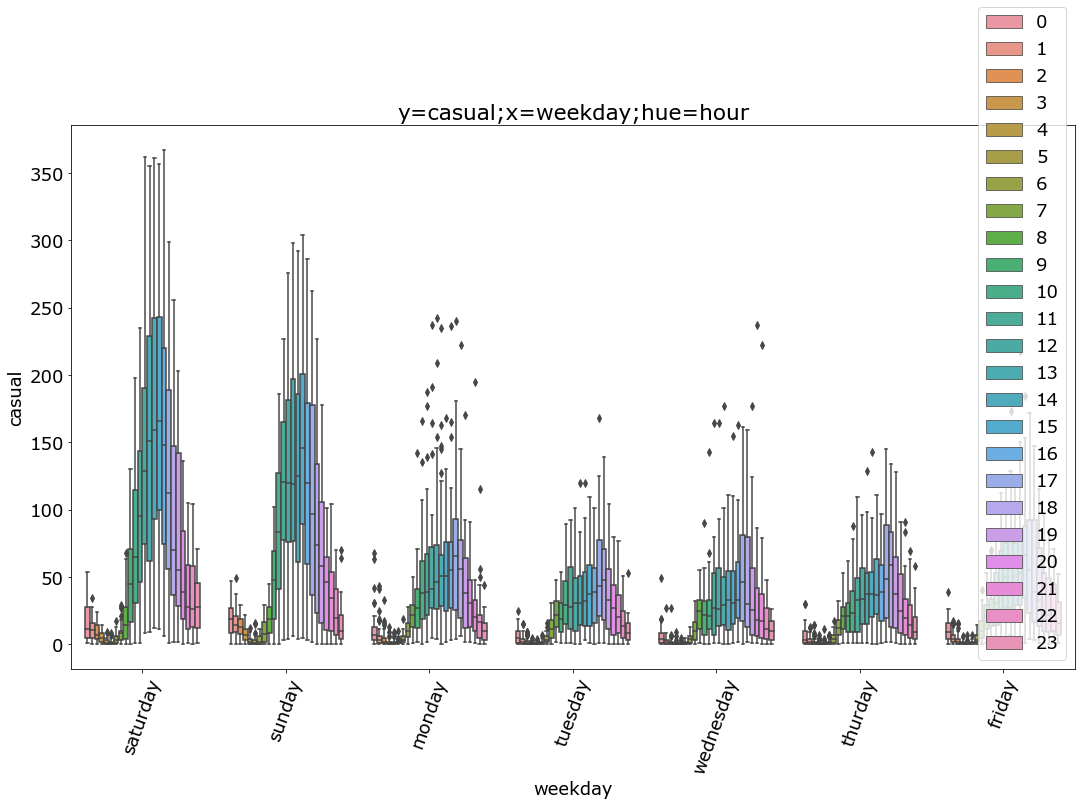

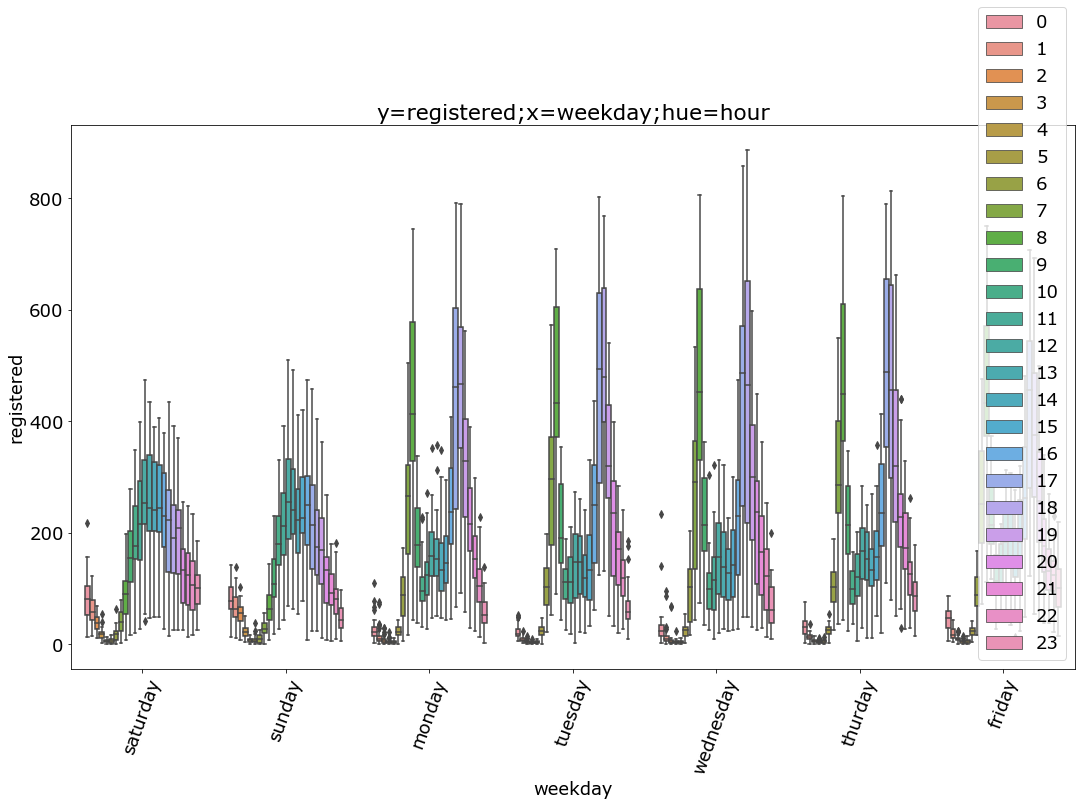

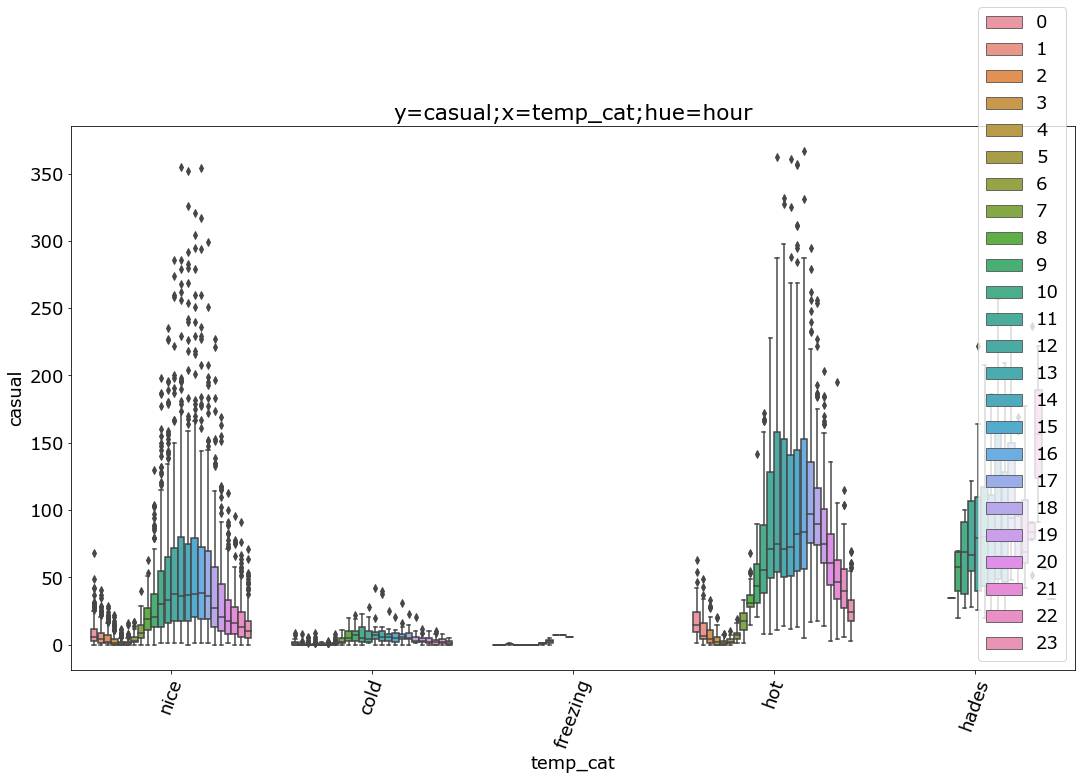

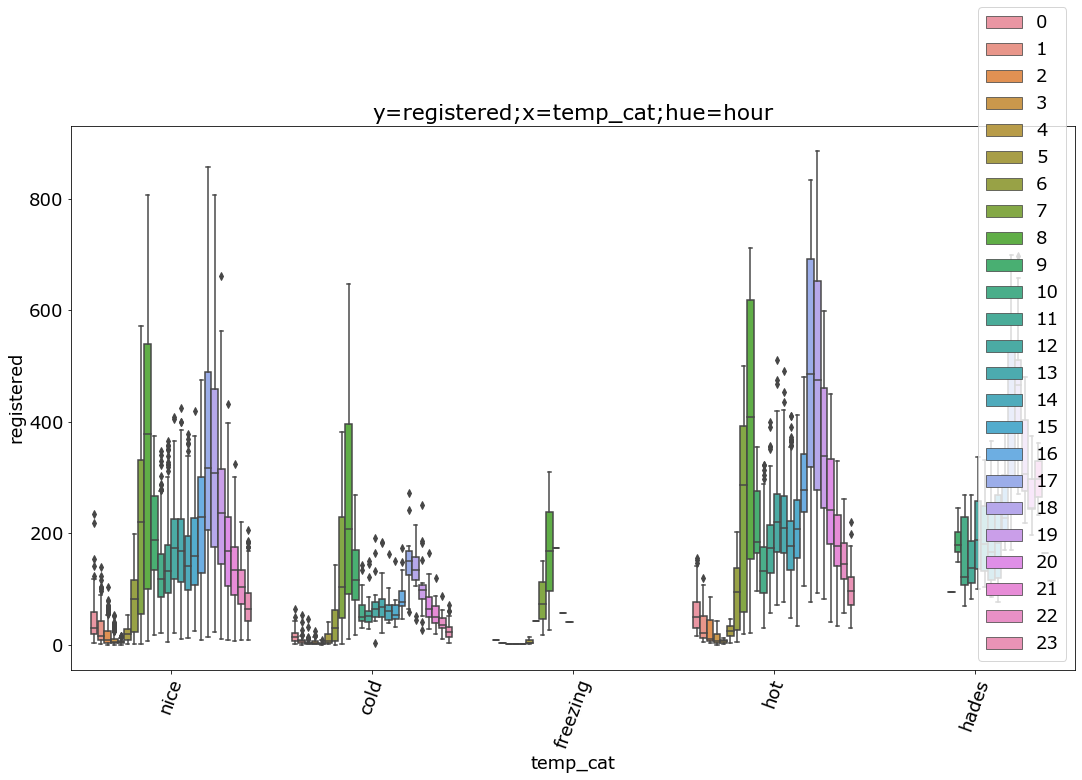

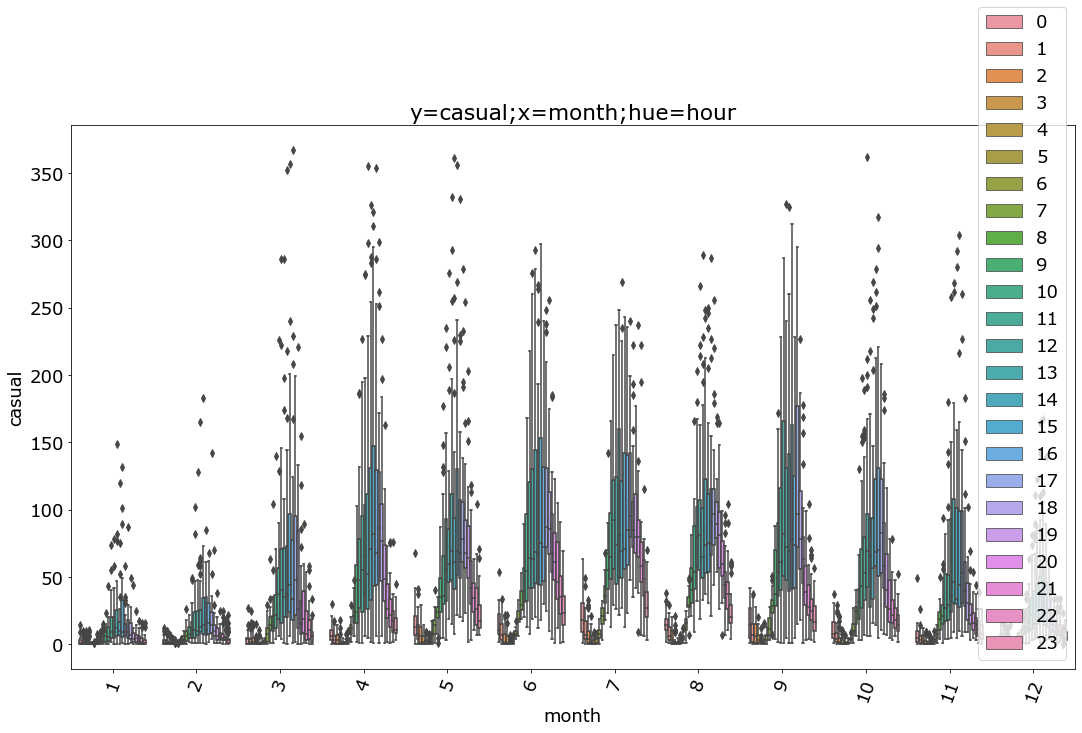

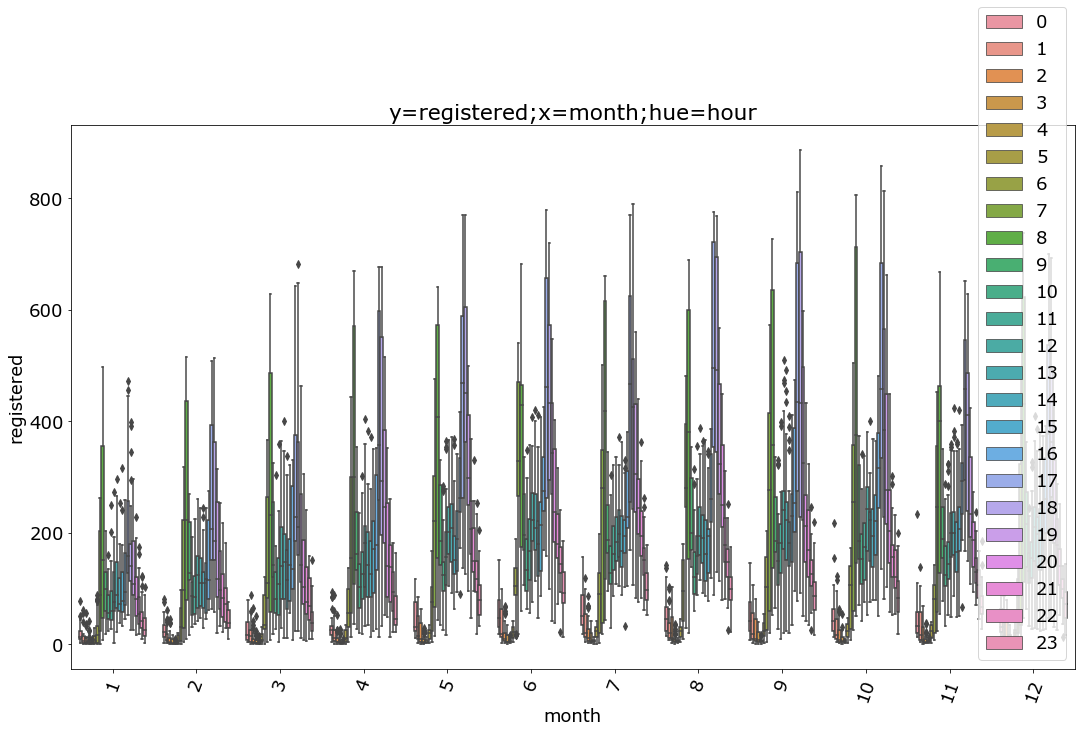

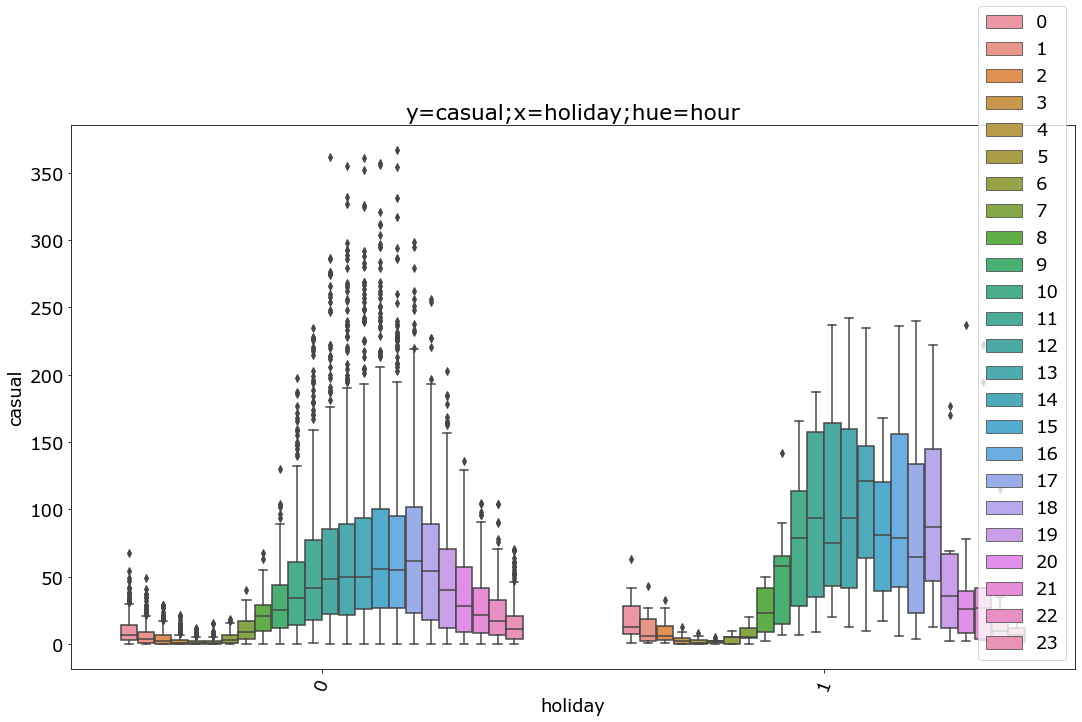

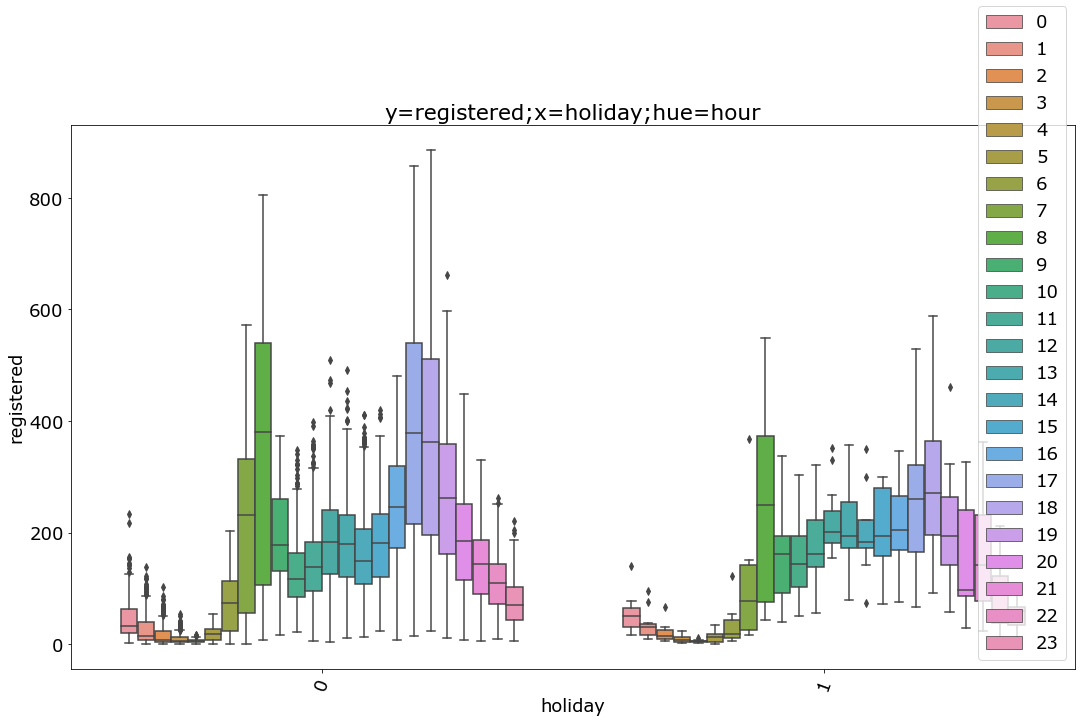

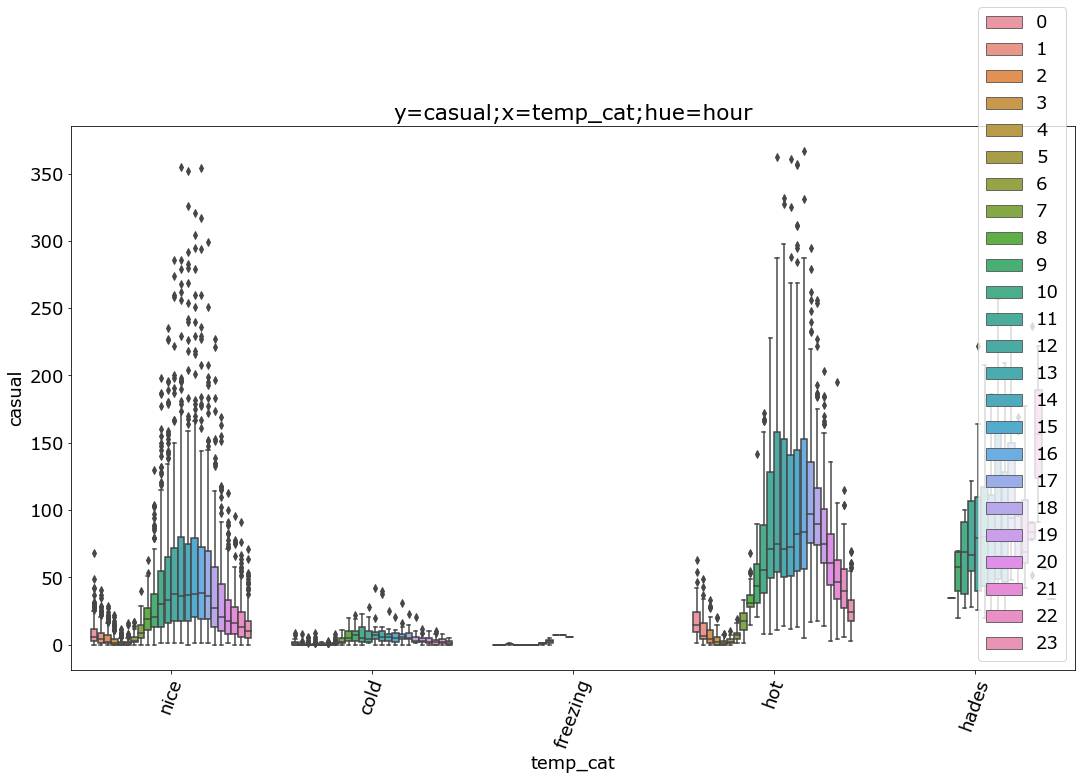

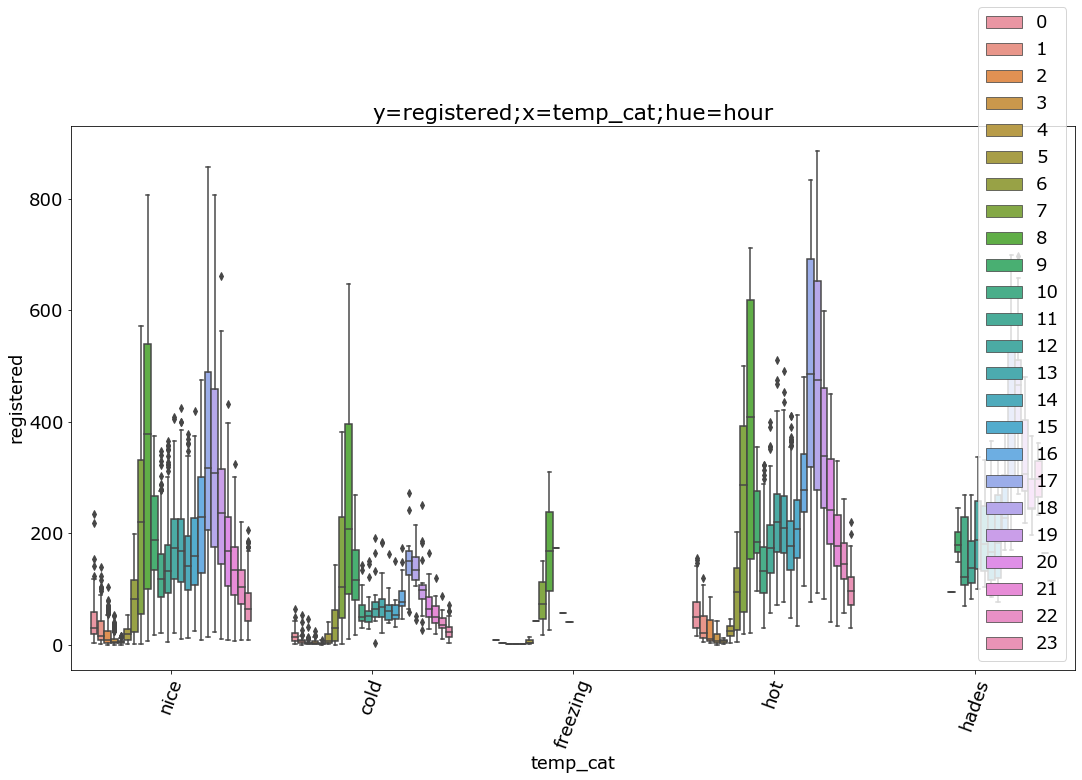

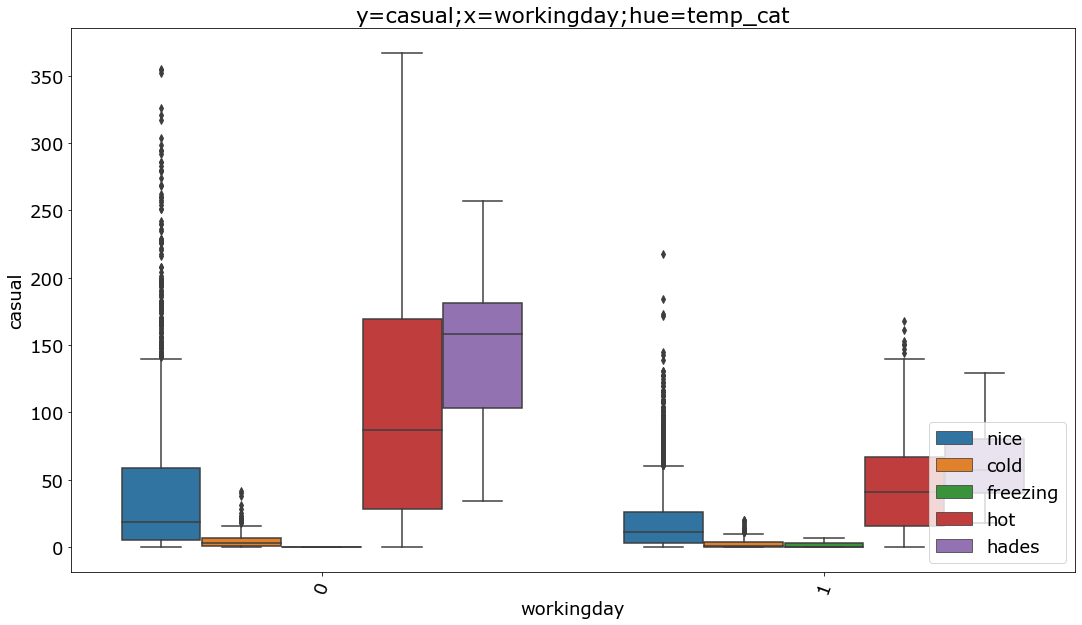

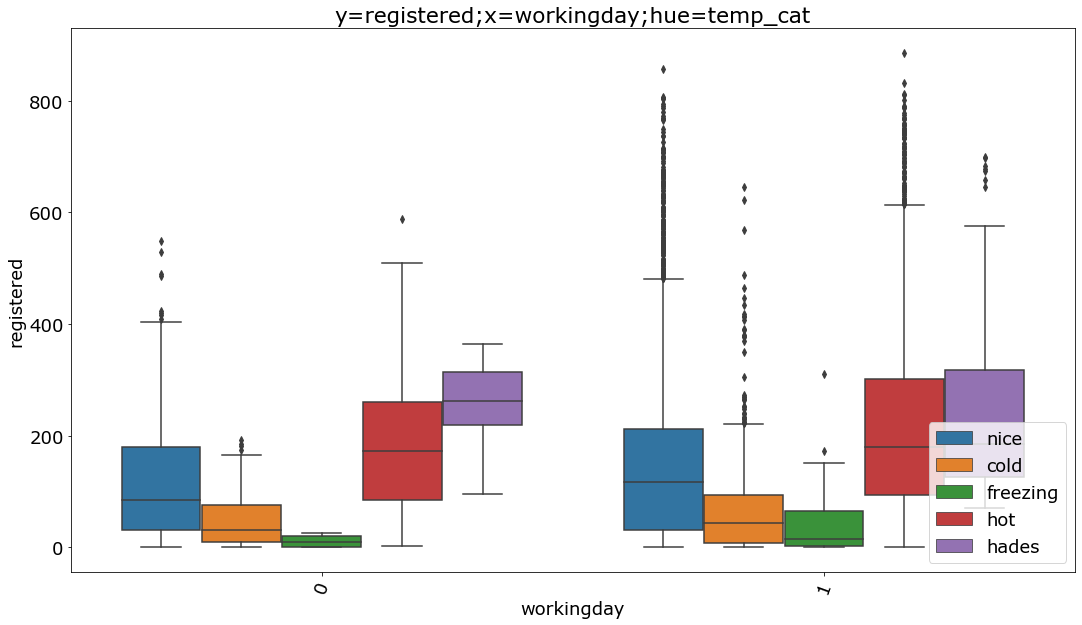

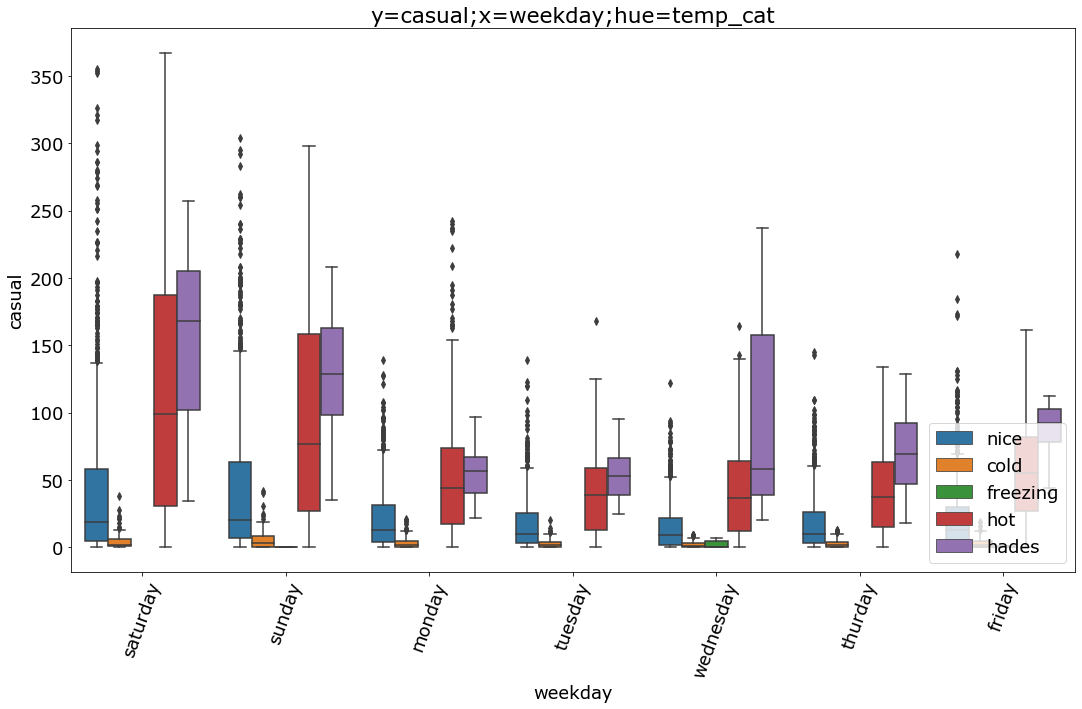

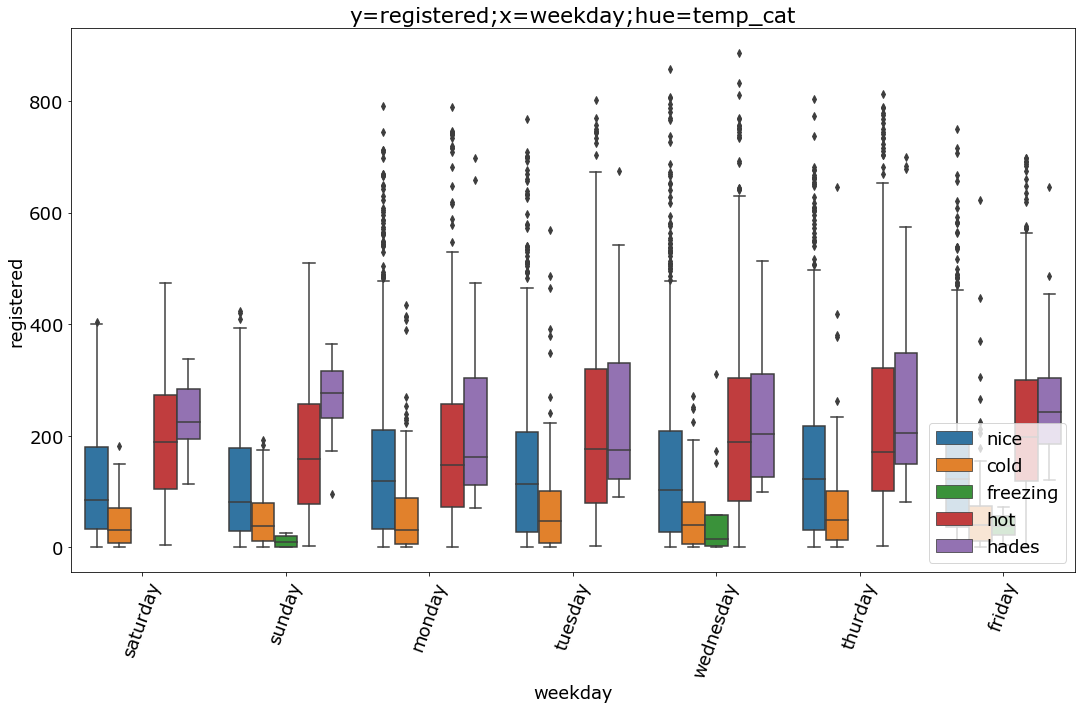

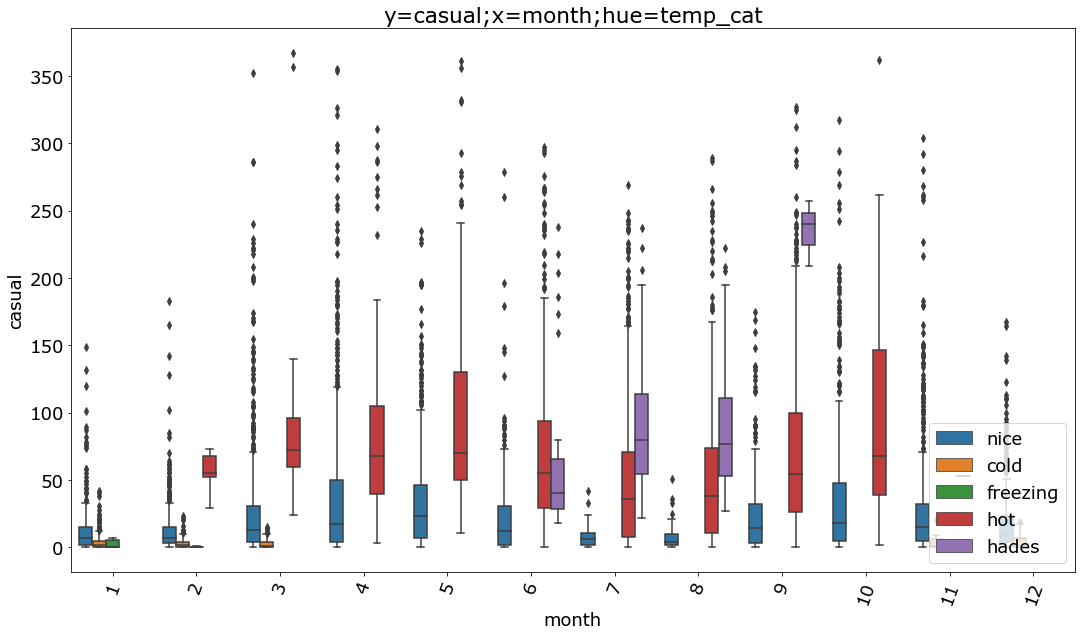

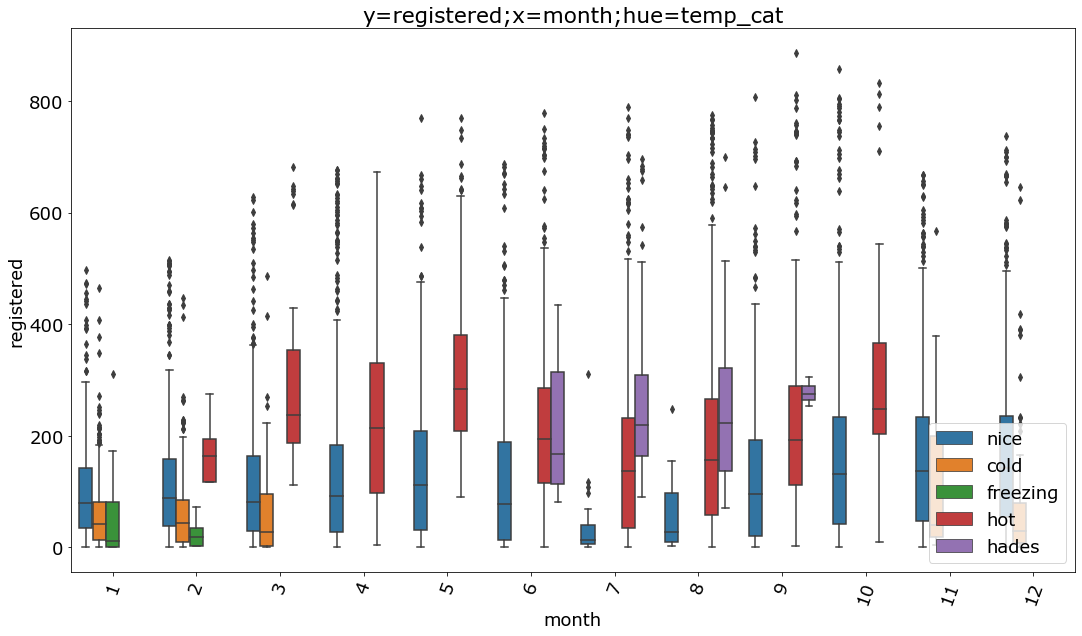

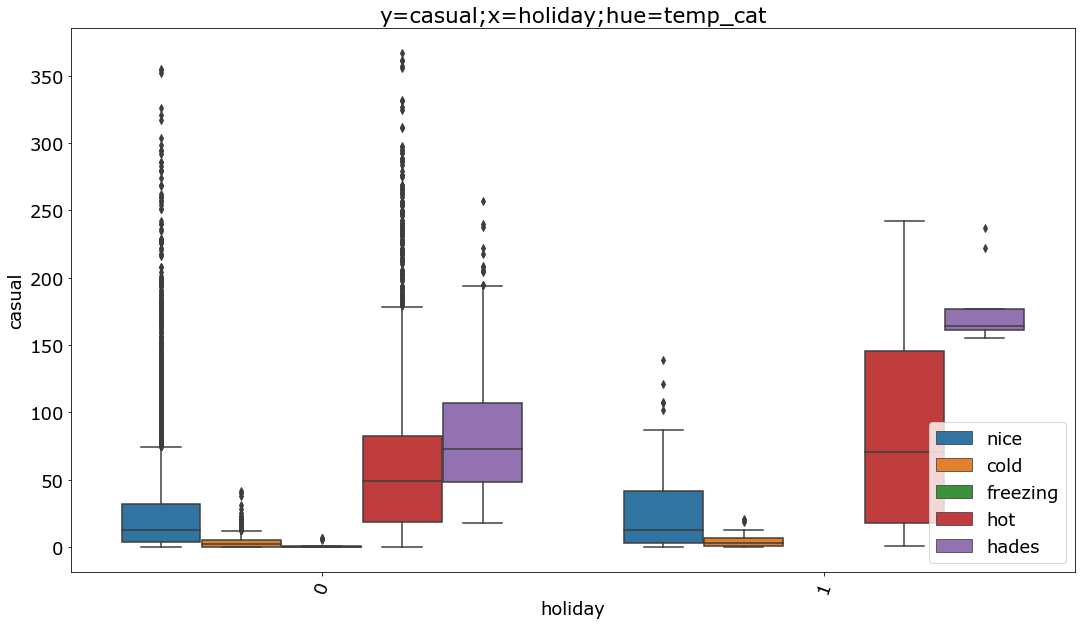

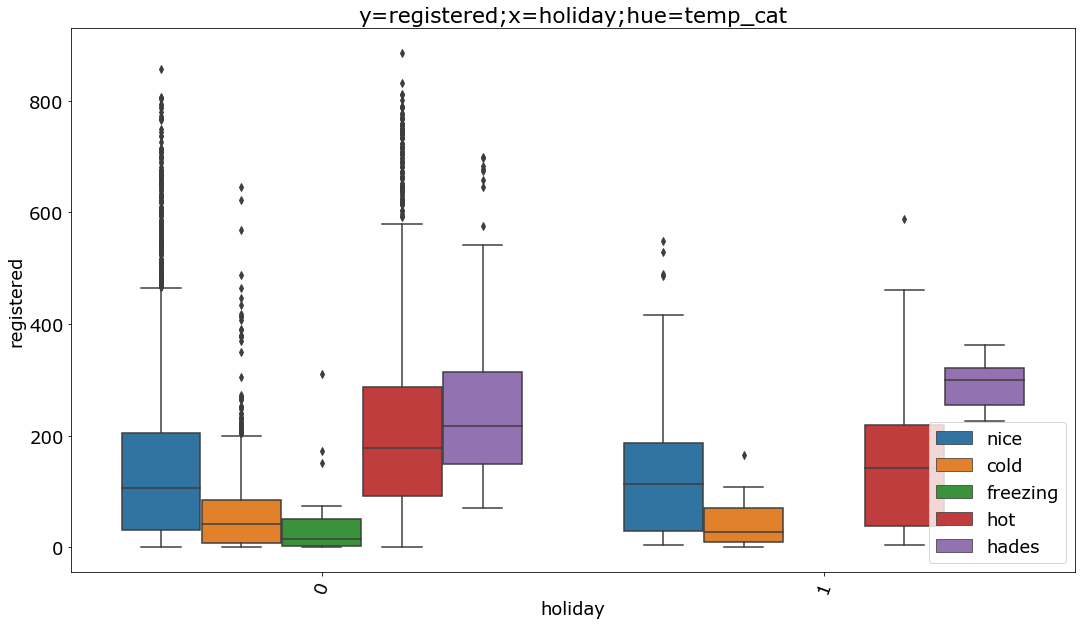

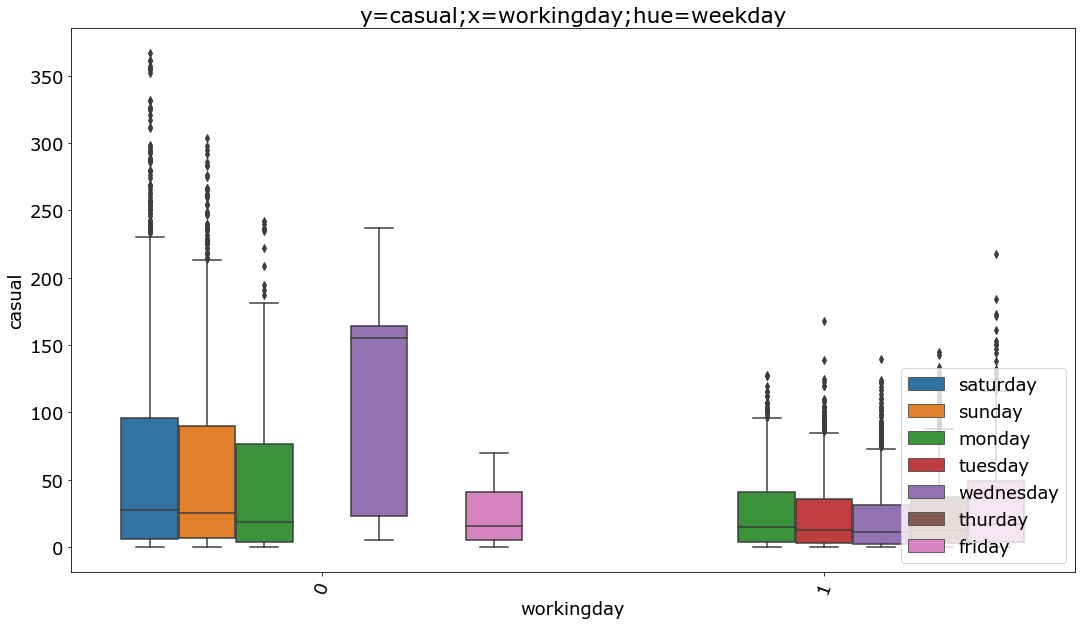

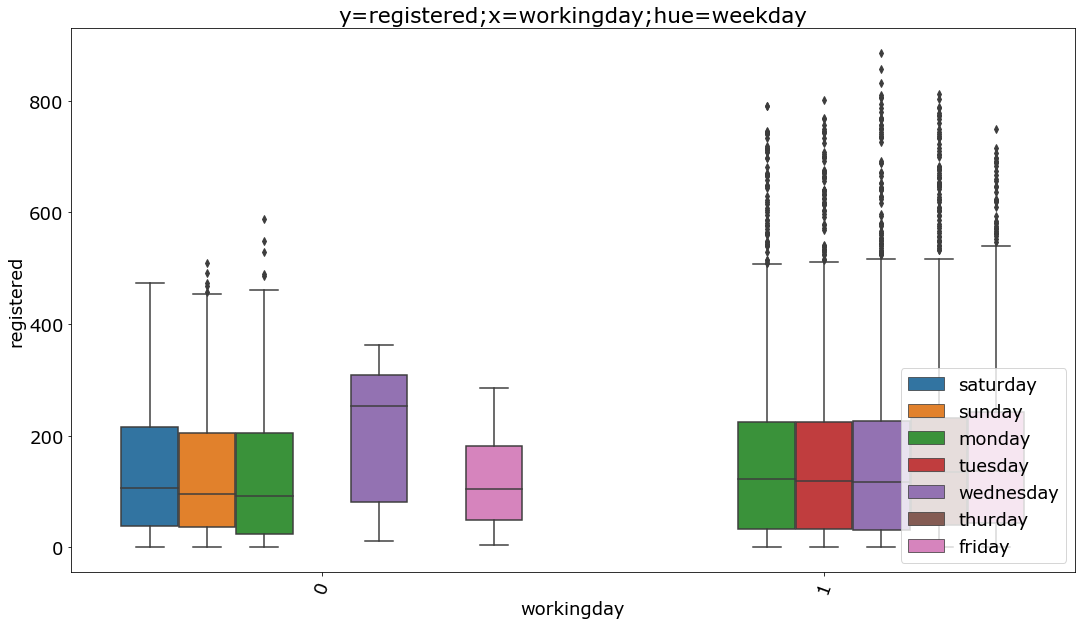

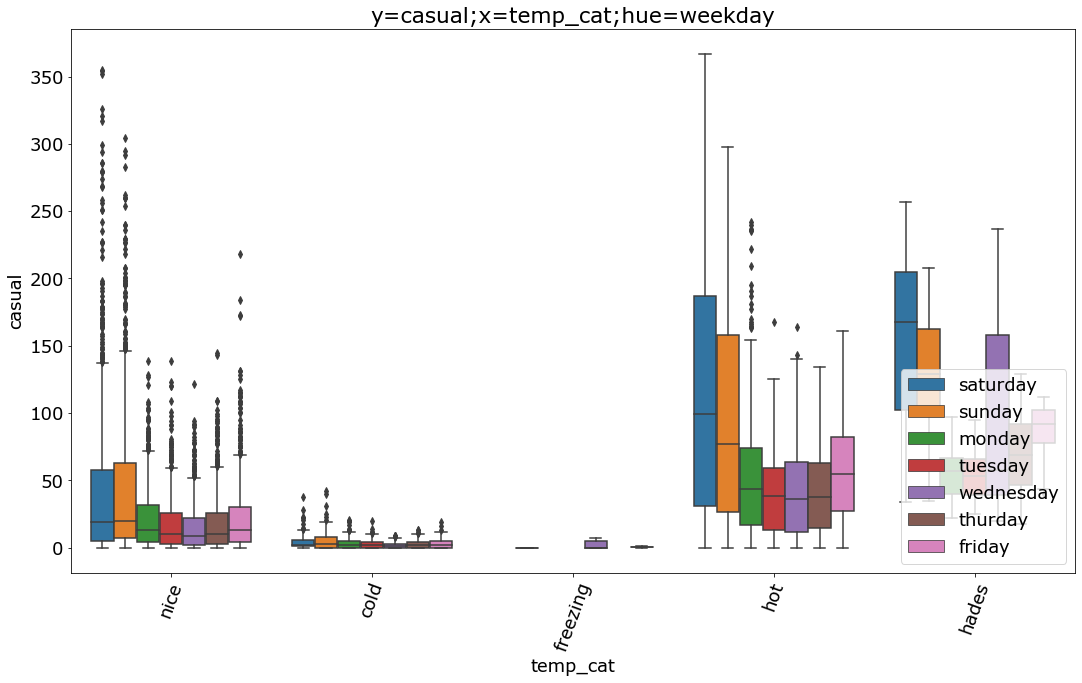

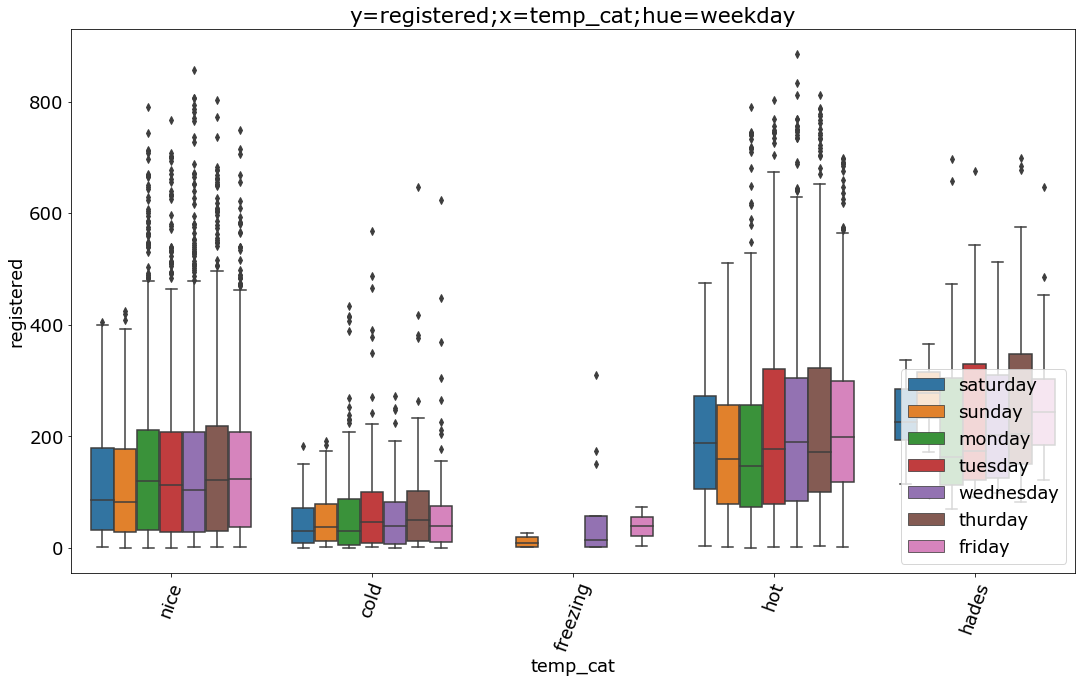

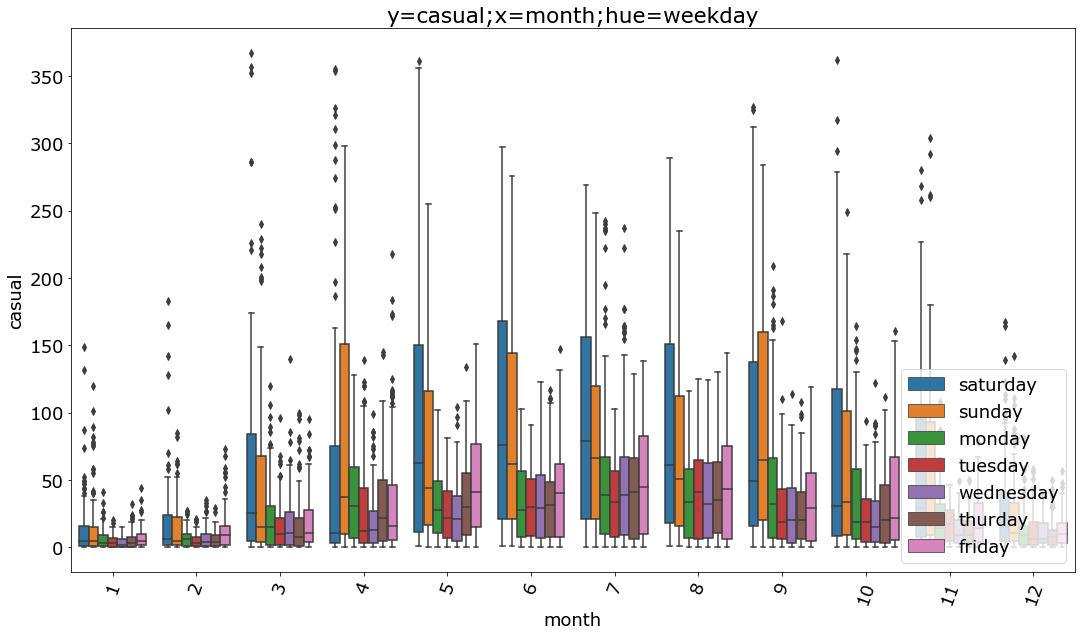

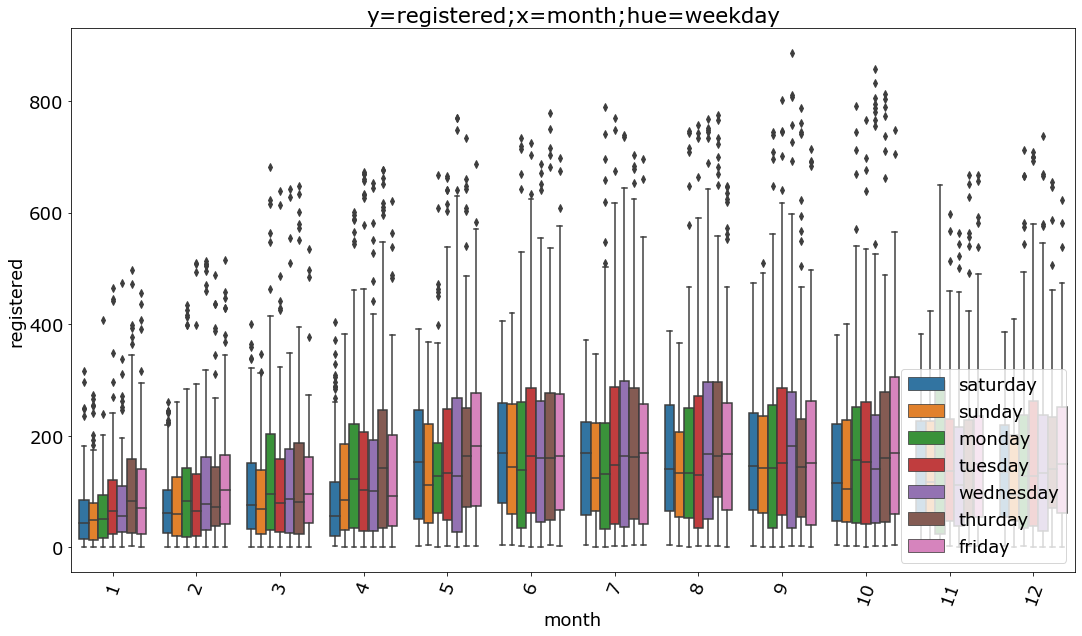

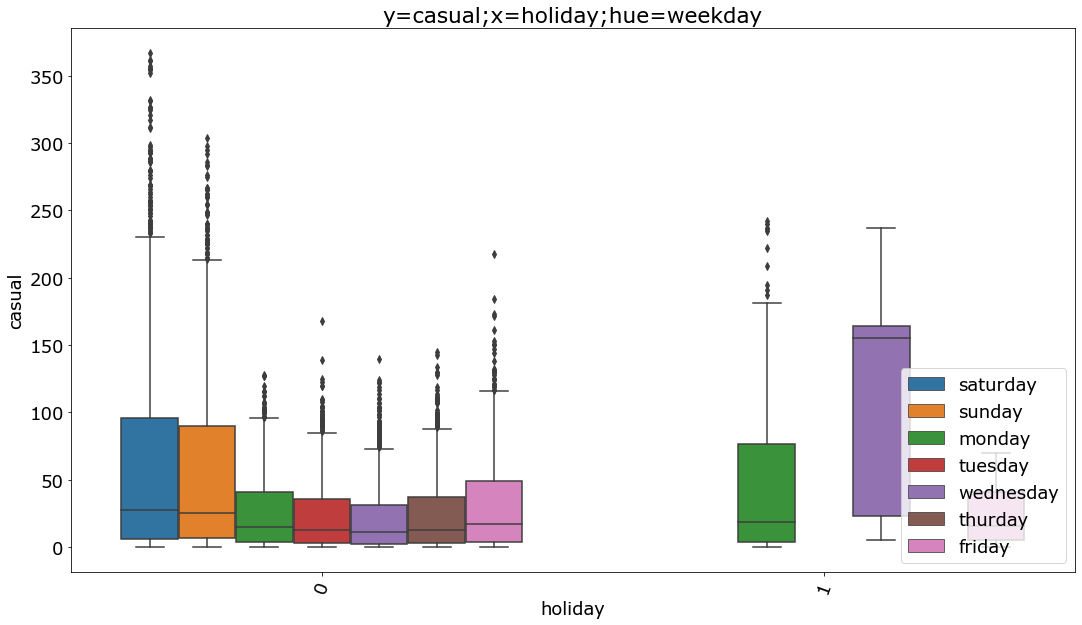

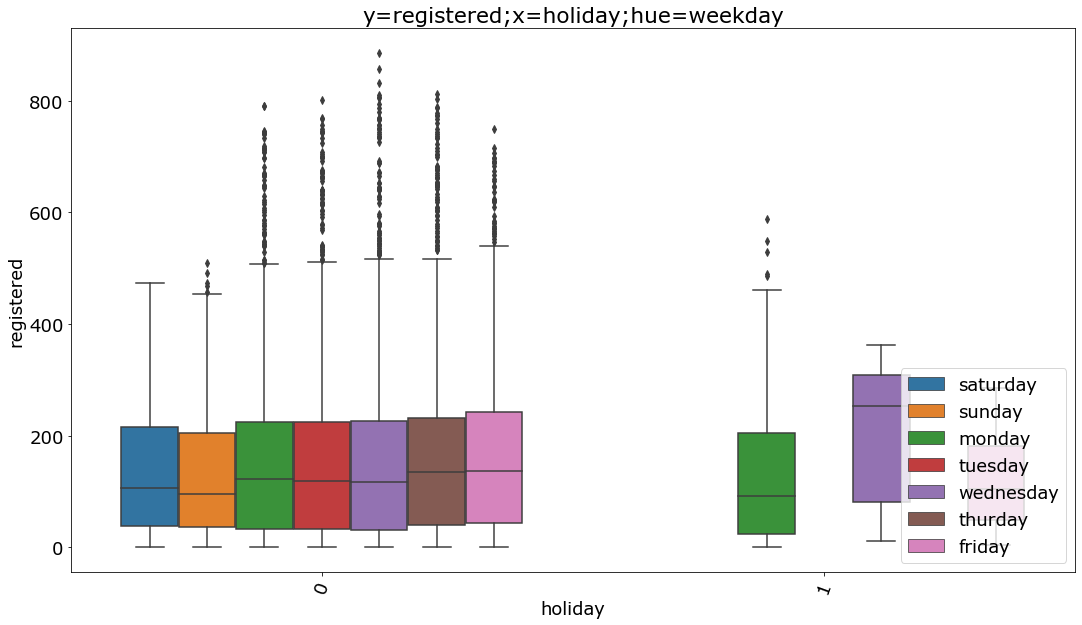

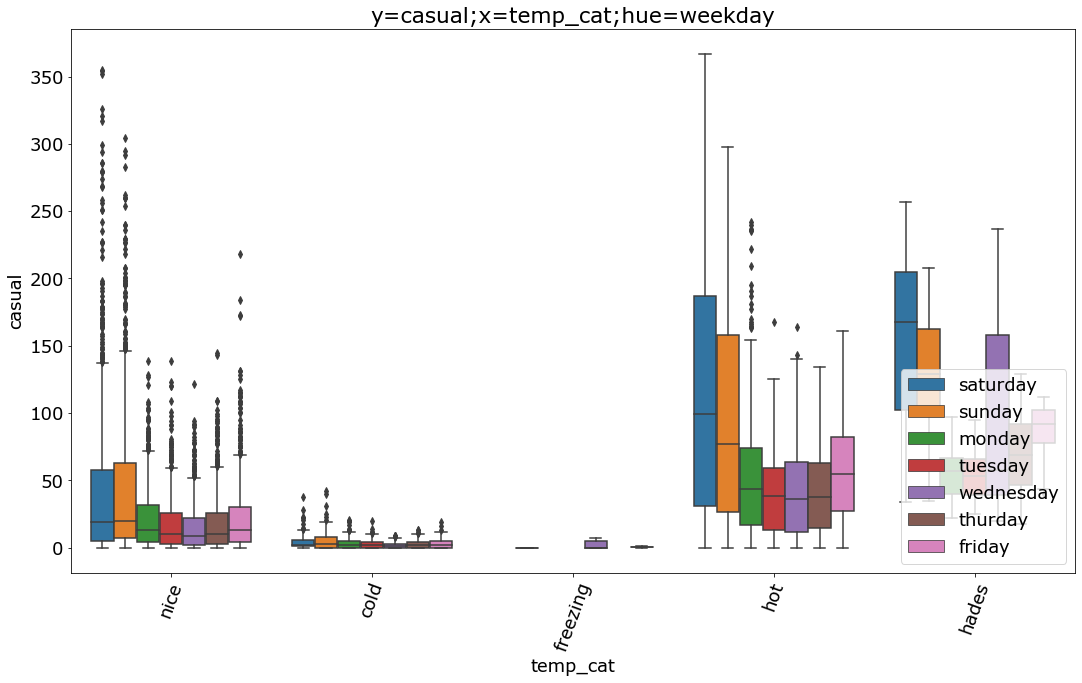

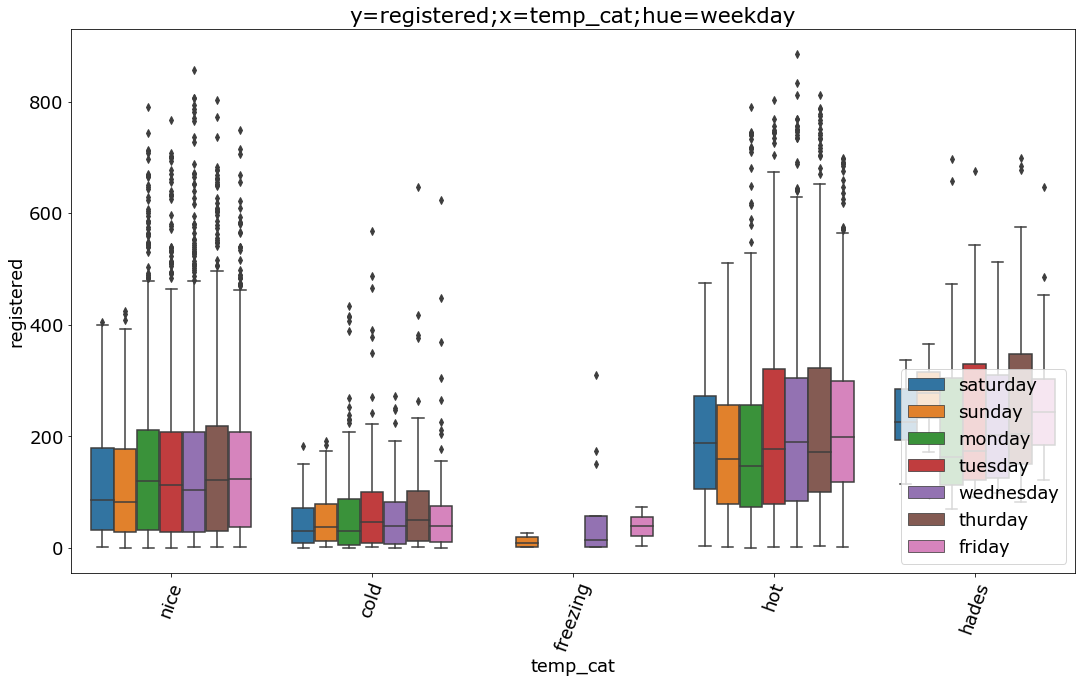

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [3]:
from scipy.constants import convert_temperature

def get_datetime(x):
    return datetime.datetime.fromisoformat(x)


season_mapper = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

weekday_mapper = {
    0: 'monday',
    1: 'tuesday',
    2: 'wednesday',
    3: 'thurday',
    4: 'friday',
    5: 'saturday',
    6: 'sunday'
    
}


    
def temp_mapper(temp=None, 
                low=12, 
                high=29):

    if temp is None:
        raise ValueError(f'temp must be a number. got {temp}')

    if temp<low//2:
        return 'freezing'
    elif temp<low:
        return 'cold'
    elif temp>=high*1.33:
        return 'hades'
    elif temp <= high:
        return 'nice'
    else:
        return 'hot'
    
# dx['season'] = [ season_mapper[s] for s in dx.season ]
# dx['year'] = [ str((get_dt(x).year - 2011)%2011+1) for x in dx.datetime ]
# dx['hour'] = [ str(get_dt(x).time().hour) for x in dx.datetime ]
# dx['month'] = [ str(get_dt(x).month) for x in dx.datetime ]
# dx['tempcat'] = list(map(temp_mapper, dx.temp))

# making cyclic time variables hour, weekday, year, month
dts = df['datetime'].copy()
df['hour'] = dts.apply(func= lambda x: get_datetime(x).hour)
df['weekday'] = dts.apply(func= lambda x: get_datetime(x).weekday())
df['weekday'] = df.weekday.apply(func=lambda x: weekday_mapper[x])
df['year'] = dts.apply(func= lambda x: (get_datetime(x).year - 2011)%2011+1)
df['month'] = dts.apply(func=lambda x: get_datetime(x).month )
# df['temp_C'] = df.temp
# df['temp_F'] = df.temp.apply(func=lambda x: convert_temperature(x, 'c', 'f'))
df['approx_temp'] = df.temp.apply(func=lambda x: round(x,1))

# temperature categories
low_temp_F, high_temp_F=49,78


df['temp_cat'] = df.temp.apply(func=lambda x : temp_mapper(temp=x,
                                                              low=convert_temperature(low_temp_F,'f','c'),
                                                              high=convert_temperature(high_temp_F,'f','c'))
                                 )
df['season'] = df.season.apply(func=lambda x: season_mapper[x])



def format_title(**kwargs):
    return ';'.join([ f'{k}={v}' for k,v in kwargs.items() ])
    
def do_plot(x,y,hue):
    dx=df.copy()
    make_big()
    sns.boxplot(x=dx[x],y=dx[y],hue=dx[hue])
    plt.xticks(rotation=70)
    plt.title(format_title(y=y, x=x, hue=hue))
    plt.legend(loc=4)
    plt.show()

    

hues = ['hour','temp_cat', 'weekday']
xs = ['workingday','weekday','temp_cat','month','holiday','temp_cat']



plots = []


for h in hues:
    for x in xs:
        for y in ['casual', 'registered']:
            if h==x:
                continue
            this = {
                'y':y,
                'x':x,
                'hue':h}
            plots.append(this)
[ do_plot(**plots[i]) for i in range(len(plots)) ]

In [4]:
df[df.temp_cat=='freezing']

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,year,month,approx_temp,temp_cat
4600,2011-01-09 04:00:00,spring,0,0,1,3.28,4.545,53,12.9980,0,1,1,4,sunday,1,1,3.3,freezing
4389,2011-01-09 05:00:00,spring,0,0,1,3.28,4.545,53,12.9980,0,1,1,5,sunday,1,1,3.3,freezing
4006,2011-02-09 02:00:00,spring,0,1,1,3.28,3.790,38,19.0012,1,2,3,2,wednesday,1,2,3.3,freezing
8447,2011-02-09 03:00:00,spring,0,1,1,2.46,3.790,45,8.9981,0,2,2,3,wednesday,1,2,2.5,freezing
383,2011-02-09 06:00:00,spring,0,1,1,2.46,7.575,45,0.0000,0,43,43,6,wednesday,1,2,2.5,freezing
2452,2011-02-11 05:00:00,spring,0,1,1,3.28,6.060,63,6.0032,0,4,4,5,friday,1,2,3.3,freezing
1687,2011-02-11 07:00:00,spring,0,1,1,3.28,8.335,73,0.0000,1,73,74,7,friday,1,2,3.3,freezing
3579,2012-01-04 00:00:00,spring,0,1,1,3.28,3.030,42,22.0028,0,9,9,0,wednesday,2,1,3.3,freezing
1595,2012-01-04 01:00:00,spring,0,1,1,1.64,1.515,38,19.9995,0,3,3,1,wednesday,2,1,1.6,freezing
3070,2012-01-04 02:00:00,spring,0,1,1,0.82,0.760,34,19.0012,0,1,1,2,wednesday,2,1,0.8,freezing


### cyclic time variables and temperature categories

In [219]:
max(df.temp)

41.0

In [220]:
df.temp_cat.value_counts()

nice        5489
hot         2247
cold         734
hades        219
freezing      19
Name: temp_cat, dtype: int64

In [85]:
convert_temperature(df.temp, 'c', 'f')

array([49.712, 49.712, 48.236, ..., 58.568, 57.092, 57.092])

In [90]:
convert_temperature

273.15

In [47]:
x_cols = [  'datetime',
            'hour',
            'weekday',
            'year',
            'month',
            'season',
            'holiday',
            'workingday',
            'weather',
            'temp',
            'atemp',
            'humidity',
            'windspeed'  ]
        

y_cols = [  'casual',
            'registered',
            'count'  ]

df = df[x_cols+y_cols]

X = df[x_cols]
y = df[y_cols]




<AxesSubplot:>

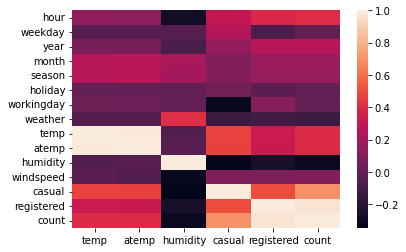

In [49]:
sns.heatmap(df.corr()[['temp','atemp','humidity']+y_cols])

In [24]:
y

,casual,registered,count
7895,3,13,16
6779,0,1,1
6508,2,0,2
4087,1,2,3
4531,1,7,8
...,...,...,...
2894,23,546,569
2079,7,329,336
217,10,231,241
4926,4,164,168


In [25]:
X.apply?

Signature:
X.apply(
    func: 'AggFuncType',
    axis: 'Axis' = 0,
    raw: 'bool' = False,
    result_type=None,
    args=(),
    **kwargs,
)
Docstring:
Apply a function along an axis of the DataFrame.

Objects passed to the function are Series objects whose index is
either the DataFrame's index (``axis=0``) or the DataFrame's columns
(``axis=1``). By default (``result_type=None``), the final return type
is inferred from the return type of the applied function. Otherwise,
it depends on the `result_type` argument.

Parameters
----------
func : function
    Function to apply to each column or row.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Axis along which the function is applied:

    * 0 or 'index': apply function to each column.
    * 1 or 'columns': apply function to each row.

raw : bool, default False
    Determines if row or column is passed as a Series or ndarray object:

    * ``False`` : passes each row or column as a Series to the
      function.
    * ``True`` : th

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday
7895,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,0,5
6779,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,4,5
6508,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,6,5
4087,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,7,5
4531,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,8,5
...,...,...,...,...,...,...,...,...,...,...,...
2894,2012-12-19 18:00:00,4,0,1,1,15.58,19.695,50,23.9994,18,2
2079,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,19,2
217,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,20,2
4926,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,21,2
